# Homework 4
#### Pierre-Antoine Desplaces, Anaïs Ladoy, Lou Richard


In [224]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
import seaborn as sns

## <b> <font color='purple'>Question 1 - Propensity score matching</font> </b>
In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

### <b> <font color='purple'>1.1 - A naive analysis</font> </b>
<b> Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis? <b>

In [225]:
# Load data
lalonde_data=pd.read_csv('lalonde.csv',index_col=0)
lalonde_data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [226]:
# Create two subsets of the dataset (one for each group)
data_control=lalonde_data[lalonde_data.treat==0]
data_treat=lalonde_data[lalonde_data.treat==1]

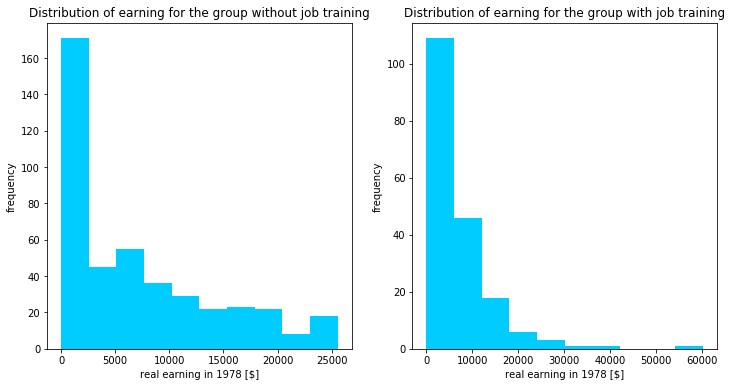

In [227]:
# Visualization of the respective distribution of the outcome variable for the two groups with an histogram 
fig = plt.figure(figsize=(12, 6))
# Histrogram for the control group
plt.subplot(1,2,1)
plt.hist(data_control.re78,color='#00ccff')
plt.title('Distribution of earning for the group without job training')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')
# Histrogram for the treated group
plt.subplot(1,2,2)
plt.hist(data_treat.re78,color='#00ccff')
plt.title('Distribution of earning for the group with job training')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')
plt.show()

First, we can see that the two distributions are highly skewed.

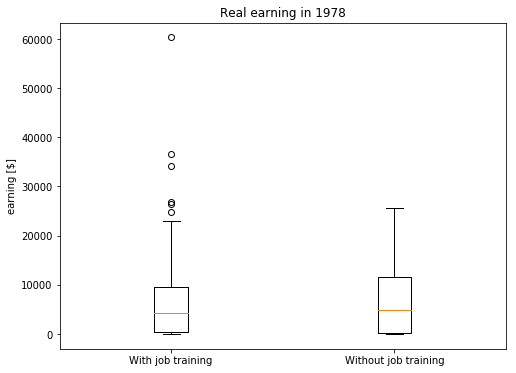

In [228]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
plt.boxplot([data_treat.re78, data_control.re78])
ax.set_title('Real earning in 1978')
ax.set_xticklabels(['With job training','Without job training'])
ax.set_ylabel('earning [$]')
plt.show()

In [229]:
stats.ks_2samp(data_treat.re78, data_control.re78)

Ks_2sampResult(statistic=0.098607698607698691, pvalue=0.15279452288468109)

Another test to compare two samples is the two-samples Kolmogorov–Smirnov test that compute the maximum distance between the two empirical functions of two samples.  
The null hypothesis of the Kolmogorov–Smirnov statistic is that the samples are drawn from the same distribution.  
Comparing the the distribution of the outcome variable for the group with and without job training program, we find a small K-S statistic value and a high p-value (15.27%), then we cannot reject the null hypothesis that the distributions are the same.

In [230]:
# Decriptive statistics for the distribution of the outcome variable
pd.DataFrame({'Without job training' :data_control.re78.describe(), 'With job training':data_treat.re78.describe()}).round(2)

,With job training,Without job training
count,185.00,429.00
mean,6349.14,6984.17
std,7867.40,7294.16
min,0.00,0.00
25%,485.23,220.18
50%,4232.31,4975.50
75%,9643.00,11688.82
max,60307.93,25564.67


### <b> <font color='purple'>1.2 - A closer look at the data</font> </b>
<b> You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis. <b>

In [231]:
print('Range of values for each feature in the dataset:')
for column in lalonde_data[lalonde_data.columns[1:]] :
    print('{} : {} - {}'.format(column,min(lalonde_data[column]),max(lalonde_data[column])))

Range of values for each feature in the dataset:
age : 16 - 55
educ : 0 - 18
black : 0 - 1
hispan : 0 - 1
married : 0 - 1
nodegree : 0 - 1
re74 : 0.0 - 35040.07
re75 : 0.0 - 25142.24
re78 : 0.0 - 60307.93


The methods to analyse the distribution between two groups change according the type of variables and in our case, we will make a distinction between the binary variables (race, married and no degree) and the continuous variables (age, education level and earnings).

#### Categorical features (Race, Married and No degree)
The goal with categorical variables is to compare the proportions of each feature between the two groups.

Compare categorical variables with chi-squared test and continuous variable with two-sample t-test.

In [232]:
control_cat=data_control[['black','hispan','married','nodegree']].apply(lambda x:(sum(x)/len(x))*100,axis=0).round(2)
treat_cat=data_treat[['black','hispan','married','nodegree']].apply(lambda x:(sum(x)/len(x))*100,axis=0).round(2)
data_cat=pd.DataFrame(np.column_stack([control_cat, treat_cat]),index=control_cat.keys(),columns=['Without Job Training (N=429)','With Job Training (N=185)'])
data_cat.index.name='Variable'
data_cat

,Without Job Training (N=429),With Job Training (N=185)
Variable,,
black,20.28,84.32
hispan,14.22,5.95
married,51.28,18.92
nodegree,59.67,70.81


In [233]:
# Chi-square test of independence between the table of contingency for two categorical variables 
def chisquare_test(var1,var2):
    contingency_table=pd.crosstab(var1,var2)
    p_value=stats.chi2_contingency(contingency)[1]
    if p_value<0.05:
        test='Significant'
    else:
        test='Not significant'
    return test

In [234]:
# Compute the chi-square test for each categorical feature and add it to the dataframe
lalonde_cat=lalonde_data[['black','hispan','married','nodegree']]
data_cat['Statistic Test Significance']=lalonde_cat.apply(lambda x: chisquare_test(lalonde_data['treat'],x), axis=0)

In [235]:
# Standardized difference for categorical variables
def stand_diff_cat(p_c,p_t):
    # Convert the percentage in proportions
    p_c=p_c/100
    p_t=p_t/100
    diff=(p_t-p_c)/(np.sqrt((p_t*(1-p_t)+p_c*(1-p_c))/2))
    return diff

In [236]:
# Compute the standardized difference between for each categorical variable
data_cat['Standardized difference']=stand_diff_cat(data_cat['Without Job Training (N=429)'],data_cat['With Job Training (N=185)'])
data_cat

,Without Job Training (N=429),With Job Training (N=185),Statistic Test Significance,Standardized difference
Variable,,,,
black,20.28,84.32,Significant,1.670617
hispan,14.22,5.95,Significant,-0.277259
married,51.28,18.92,Significant,-0.720679
nodegree,59.67,70.81,Significant,0.235548


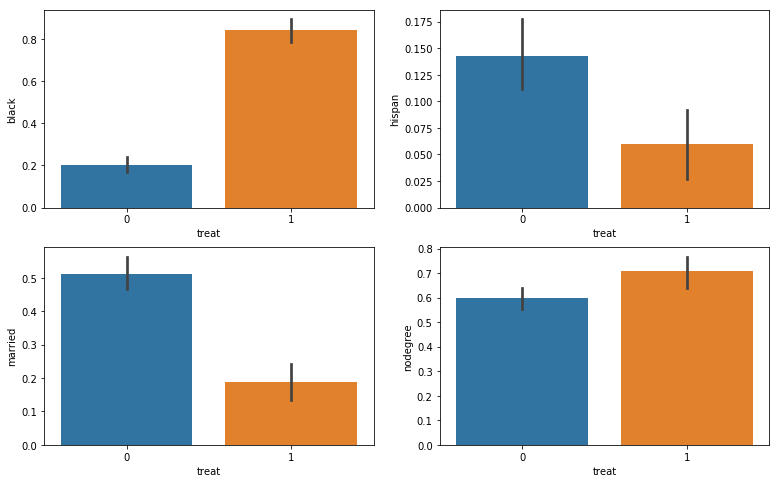

In [237]:
# Compare the distribution of the different continuous features between the two groups (treat and no treat)
fig = plt.figure(1, figsize=(13, 8))
plt.subplot(2,2,1)
sns.barplot(x="treat",y="black",data=lalonde_data)
plt.subplot(2,2,2)
sns.barplot(x="treat",y="hispan",data=lalonde_data)
plt.subplot(2,2,3)
sns.barplot(x="treat",y="married",data=lalonde_data)
plt.subplot(2,2,4)
sns.barplot(x="treat",y="nodegree",data=lalonde_data)
plt.show()

#### Continuous features (Age, Education level and Earnings)

In [238]:
control_cont=data_control[['age','educ','re74','re75','re78']].groupby(lambda idx: 0).agg(['mean','std']).round(2).transpose()
treat_cont=data_treat[['age','educ','re74','re75','re78']].groupby(lambda idx: 0).agg(['mean','std']).round(2).transpose()
data_cont=pd.concat([control_cont,treat_cont],axis=1)
data_cont.columns=['Without Job Training (N=429)','With Job Training (N=185)']
data_cont

Without Job Training (N=429)  With Job Training (N=185)
age  mean                         28.03                      25.82
     std                          10.79                       7.16
educ mean                         10.24                      10.35
     std                           2.86                       2.01
re74 mean                       5619.24                    2095.57
     std                        6788.75                    4886.62
re75 mean                       2466.48                    1532.06
     std                        3292.00                    3219.25
re78 mean                       6984.17                    6349.14
     std                        7294.16                    7867.40

In [239]:
# Two sample t-test
def t_test(var1,var2):
    p_value=stats.ttest_ind(var1, var2, equal_var=False)[1]
    if p_value<0.05:
        test='Significant'
    else:
        test='Not significant'
    return test

In [240]:
lalonde_cont=lalonde_data[['age','educ','re74','re75','re78']]
# Compute the two samples t-test for each continuous variable
t_test_res=lalonde_cont.apply(lambda x: chisquare_test(lalonde_data['treat'],x), axis=0)
# Add result to dataframe
data_cont.loc[[('age','mean'),('educ','mean'),('re74','mean'),('re75','mean'),('re78','mean')],'Test Significance']=list(zip(t_test_res))

In [241]:
# Standardized difference for continuous variables
def stand_diff_cont(x_c,sd_c,x_t,sd_t):
    diff=(x_t-x_c)/(np.sqrt((sd_t**2+sd_c**2)/2))
    return diff

In [243]:
# Compute the standardized difference for each continuous variable and add the result to the dataframe in the same time
data_cont.loc[('age','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('age','mean'),'Without Job Training (N=429)'],data_cont.loc[('age','std'),'Without Job Training (N=429)'],data_cont.loc[('age','mean'),'With Job Training (N=185)'],data_cont.loc[('age','std'),'With Job Training (N=185)'])
data_cont.loc[('educ','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('educ','mean'),'Without Job Training (N=429)'],data_cont.loc[('educ','std'),'Without Job Training (N=429)'],data_cont.loc[('educ','mean'),'With Job Training (N=185)'],data_cont.loc[('educ','std'),'With Job Training (N=185)'])
data_cont.loc[('re74','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('re74','mean'),'Without Job Training (N=429)'],data_cont.loc[('re74','std'),'Without Job Training (N=429)'],data_cont.loc[('re74','mean'),'With Job Training (N=185)'],data_cont.loc[('re74','std'),'With Job Training (N=185)'])
data_cont.loc[('re75','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('re75','mean'),'Without Job Training (N=429)'],data_cont.loc[('re75','std'),'Without Job Training (N=429)'],data_cont.loc[('re75','mean'),'With Job Training (N=185)'],data_cont.loc[('re75','std'),'With Job Training (N=185)'])
data_cont.loc[('re78','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('re78','mean'),'Without Job Training (N=429)'],data_cont.loc[('re78','std'),'Without Job Training (N=429)'],data_cont.loc[('re78','mean'),'With Job Training (N=185)'],data_cont.loc[('re78','std'),'With Job Training (N=185)'])
data_cont = data_cont.replace(np.nan, '', regex=True)
data_cont


Without Job Training (N=429)  With Job Training (N=185)  \
age  mean                         28.03                      25.82   
     std                          10.79                       7.16   
educ mean                         10.24                      10.35   
     std                           2.86                       2.01   
re74 mean                       5619.24                    2095.57   
     std                        6788.75                    4886.62   
re75 mean                       2466.48                    1532.06   
     std                        3292.00                    3219.25   
re78 mean                       6984.17                    6349.14   
     std                        7294.16                    7867.40   

          Test Significance Standardized difference  
age  mean       Significant               -0.241354  
     std                                             
educ mean       Significant               0.0445018  
     std                                             
re74 mean       Significant               -0.595753  
     std                                             
re75 mean       Significant               -0.286999  
     std                                             
re78 mean       Significant              -0.0837086  
     std

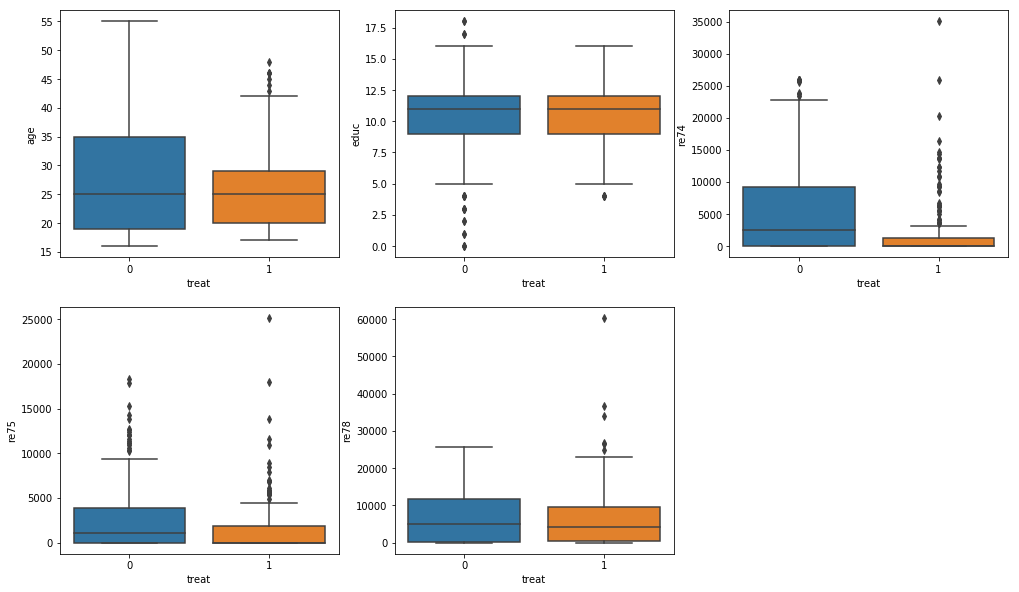

In [244]:
# Compare the distribution of the different continuous features between the two groups (treat and no treat)
fig = plt.figure(1, figsize=(17, 10))
plt.subplot(2,3,1)
sns.boxplot(x='treat', y='age', data=lalonde_data)
plt.subplot(2,3,2)
sns.boxplot(x='treat', y='educ', data=lalonde_data)
plt.subplot(2,3,3)
sns.boxplot(x='treat', y='re74', data=lalonde_data)
plt.subplot(2,3,4)
sns.boxplot(x='treat', y='re75', data=lalonde_data)
plt.subplot(2,3,5)
sns.boxplot(x='treat', y='re78', data=lalonde_data)
plt.show()

### <b> <font color='purple'>1.3 - A propensity score model</font> </b>
<b> Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).) <b>

In [245]:
from sklearn import linear_model

Logistic regression used to estimate the probability of a binary response based on one or more predictor (or independent) variables (features). It allows one to say that the presence of a risk factor increases the odds of a given outcome by a specific factor.

"In propensity-score model, we assumed a linear relationship between continuous covariates and the log-odds of receiving treatment (acces job training program)."

In [246]:
covariates=lalonde_data.drop(['treat'],axis=1)
covariates.head()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,
NSW1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,33,8,1,0,0,1,0.0,0.0,289.7899


In [247]:
# Create a Logistic Regression model
logistic = linear_model.LogisticRegression()

# Fit the model with X (covariates) and y (dependent variable)
X=lalonde_data.drop(['treat'],axis=1)
y=lalonde_data.treat
logistic = logistic.fit(X, y)

# check the accuracy on the training set
logistic.score(covariates, lalonde_data.treat)

# Probability estimates of the logistic regression that are equal to the propensity scores
# Select only the first column that corresponds to the probability of being selected in the treatment group (treat=1)
prop_score=logistic.predict_proba(X)[:,1]

In [248]:
# Add the propensity score for each point in our dataset
lalonde_data['Propensity Score']=prop_score.tolist()
lalonde_data.head(10)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Propensity Score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.670590
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0.711254
NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0.649616
NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0.660434
NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0.583820


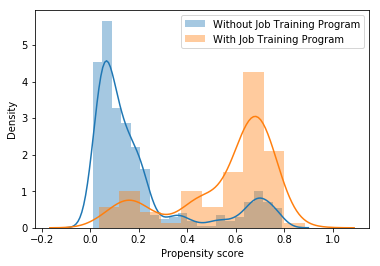

In [260]:
# Check that the propensity score is balanced across treatment and comparison group
data_control=lalonde_data[lalonde_data.treat==0]
data_treat=lalonde_data[lalonde_data.treat==1]
fig, ax = plt.subplots()
sns.distplot(data_control['Propensity Score'],label="Without Job Training Program",ax=ax)
sns.distplot(data_treat['Propensity Score'],label="With Job Training Program",ax=ax)
ax.legend()
ax.set_xlabel('Propensity score')
ax.set_ylabel('Density')
plt.show()

### <b> <font color='purple'>1.4 - Balancing the dataset via matching</font> </b>
<b> Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before? <b>

In [270]:
import networkx as nx
from networkx.algorithms import bipartite
B=nx.Graph()
B.add_nodes_from(lalonde_data[lalonde_data.treat==0]['Propensity Score'], bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(lalonde_data[lalonde_data.treat==1]['Propensity Score'], bipartite=1)
#nx.bipartite.maximum_matching(B)
nx.is_connected(B)

False

Therefore, the appropriateness of the specification of the propensity score is assessed by examining the degree to which matching on the estimated propensity score has resulted in a matched sample in which the distribution of measured baseline covariates is similar between treated and untreated subjects (removed observed systematic differences between treated and untreated subjects)

### <b> <font color='purple'>1.5 - Balancing the groups further</font> </b>
<b> Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4. <b>

### <b> <font color='purple'>1.6 - A less naive analysis</font> </b>
<b> Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program? <b>

## <b> <font color='purple'>Question 2 - Applied ML</font> </b>
<b>We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!<b>

### <b> <font color='purple'>2.1</font> </b>
<b> Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâinverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category). <b>

### <b> <font color='purple'>2.2</font> </b>
<b> Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.
 <b>